<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 4: Web Scraping Job Postings

# Business Case Overview

You're working as a data scientist for a contracting firm that's rapidly expanding. Now that they have their most valuable employee (you!), they need to leverage data to win more contracts. Your firm offers technology and scientific solutions and wants to be competitive in the hiring market. Your principal has two main objectives:

   1. Determine the industry factors that are most important in predicting the salary amounts for these data.
   2. Determine the factors that distinguish job categories and titles from each other. For example, can required skills accurately predict job title?

To limit the scope, your principal has suggested that you *focus on data-related job postings*, e.g. data scientist, data analyst, research scientist, business intelligence, and any others you might think of. You may also want to decrease the scope by *limiting your search to a single region.*

Hint: Aggregators like [Indeed.com](https://www.indeed.com) regularly pool job postings from a variety of markets and industries. 

**Goal:** Scrape your own data from a job aggregation tool like Indeed.com in order to collect the data to best answer these two questions.

---

## Directions

In this project you will be leveraging a variety of skills. The first will be to use the web-scraping and/or API techniques you've learned to collect data on data jobs from Indeed.com or another aggregator. Once you have collected and cleaned the data, you will use it to answer the two questions described above.

---

In [1]:
# data modules
import numpy as np
import scipy.stats as stats
import pandas as pd

# visualization modules
import seaborn as sns
import matplotlib.pyplot as plt

# feature selection and preprocessing modules
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.preprocessing import StandardScaler

# modeling modules
from sklearn.model_selection import cross_val_score, train_test_split,\
GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import classification_report, roc_curve, auc,\
confusion_matrix

# import NLP modules
from sklearn.naive_bayes import BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer

sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# make sure plots appear in Jupyter notebook
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Hide warnings
import warnings

warnings.filterwarnings('ignore')

# enable viewing of all columns & rows for DataFrames
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Question 1 - Factors that impact salary

To predict salary you will be building either a classification or regression model, using features like the <font color=red>location, title, and summary of the job</font>. If framing this as a regression problem, you will be estimating the listed salary amounts. You may instead choose to frame this as a classification problem, in which case you will <font color=red>create labels from these salaries (high vs. low salary</font>, for example) according to <font color=red>thresholds (such as median salary</font>).

You have learned a variety of new skills and models that may be useful for this problem:
- NLP
- Unsupervised learning and dimensionality reduction techniques (PCA, clustering)
- Ensemble methods and decision tree models
- SVM models

Whatever you decide to use, the most important thing is to justify your choices and interpret your results. <font color=red>*Communication of your process is key.*</font> Note that most listings **DO NOT** come with salary information. You'll need to able to extrapolate or predict the expected salaries for these listings.

In [2]:
df = pd.read_csv('project4_compiled.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4736 entries, 0 to 4735
Data columns (total 11 columns):
url                         4736 non-null object
company_name                4736 non-null object
job_title                   4736 non-null object
location                    4736 non-null object
employment_type             4736 non-null object
seniority                   4736 non-null object
job_category                4736 non-null object
salary_range                4736 non-null object
salary_freq                 4207 non-null object
roles & responsibilities    4736 non-null object
requirements                4736 non-null object
dtypes: object(11)
memory usage: 407.1+ KB


In [3]:
df.head()

,url,company_name,job_title,location,employment_type,seniority,job_category,salary_range,salary_freq,roles & responsibilities,requirements
0,https://www.mycareersfuture.sg/job/senior-staf...,GE MEASUREMENT AND CONTROL (SINGAPORE) PTE. LTD.,Senior Staff Data Engineer,"THE METROPOLIS, 11 NORTH BUONA VISTA DRIVE 138589",Permanent,Senior Executive,Information Technology,"$8,000to$10,000",Monthly,Role Summary/Purpose :This role will be part o...,Qualifications/Requirements :• Bachelor’s/Mast...
1,https://www.mycareersfuture.sg/job/data-engine...,MORGAN MCKINLEY PTE. LTD.,Data Engineer,"ONE RAFFLES PLACE, 1 RAFFLES PLACE 048616",Permanent,Senior Executive,Information Technology,"$3,300to$6,300",Monthly,You will participate in constructing internat...,"1. Major in computer science, mathematics, st..."
2,https://www.mycareersfuture.sg/job/data-engine...,AFFABLE TECHNOLOGIES PTE. LTD.,Data Engineer,"HIGH STREET CENTRE, 1 NORTH BRIDGE ROAD 179094",Full Time,Professional,Information Technology,"$4,000to$7,000",Monthly,Affable is a venture-backed startup in Singapo...,Data Mining Big Data Data Warehousing Data Scr...
3,https://www.mycareersfuture.sg/job/data-intern...,SMARTKARMA INNOVATIONS PTE. LTD.,Data Intern,"THE SIGNATURE, 51 CHANGI BUSINESS PARK CENTRAL...",Internship,"Fresh/entry level, Executive","Admin / Secretarial, Banking and Finance","$1,000to$1,000",Monthly,Important: Please complete the Smartkarma Data...,Required Skills Great attention to detail ...
4,https://www.mycareersfuture.sg/job/big-data-en...,ERNST & YOUNG ADVISORY PTE. LTD.,Big Data Engineer (Financial Services),1 RAFFLES QUAY 048583,Full Time,Manager,"Consulting , Banking and Finance, Information ...","$6,800to$13,600",Monthly,We are the only professional services organisa...,Skills and attributes for success Leverage te...


<div class='alert alert-warning'>

### Objective: find out what factors influence salary

The dataset is messy and mainly just text.
We need to first clean the dataset by removing unwanted characters, extract useful features, then visualize each feature to check and remove outliers.
As the dataset is quite large (4736 rows), we can reduce its dimensions by using only related jobs for modeling.

<div class='alert alert-danger'>

### Data cleaning steps:

i) standardize text in dataframe to lowercase


ii) remove unwanted characters from the columns (salary, job title, roles & responsibilities, requirements)


iii) replace 'None' values with nan

In [4]:
## convert text in dataframe to lowercase

for i in df.columns:
    df[i] = df[i].str.lower()

In [5]:
## clean up salary column

df['salary_range'] = df['salary_range'].map(lambda x:x.replace('$','').\
                            replace(',','').replace('to','-').\
                            replace('salary undisclosed','none-none'))

In [6]:
for c in ['job_title','roles & responsibilities','requirements']:
    df[c] = df[c].str.replace('[^a-zA-Z\d\s]','')

# ^ negates what follows, \d means digits, \s means whitespace, 
# a-zA-Z matches upper and lower case letters

In [7]:
## replace 'None' values with nan

df = df.replace(to_replace='None', value=np.nan)
df.isnull().sum()

url                           0
company_name                  0
job_title                     0
location                      0
employment_type               0
seniority                     0
job_category                  0
salary_range                  0
salary_freq                 529
roles & responsibilities      0
requirements                  0
dtype: int64

<div class='alert alert-danger'>

### Feature engineering 1:

i) split salary range into upper and lower bounds


ii) convert annual salaries into their monthly equivalents


iii) find the mean salary for each job


iv) drop jobs with undisclosed salaries


v) visualize lower/higher salary bound, mean salary


vi) examine outlier jobs


vii) remove jobs with <font color=blue>mean monthly salaries above 30,000</font> as they appear to be mistakes

In [8]:
## split salary range into higher and lower bounds

sal = df['salary_range'].str.split("-", n=1, expand=True)

df['salary_lower'] = sal[0]
df['salary_upper'] = sal[1]

df['salary_lower'] = df['salary_lower'].replace(to_replace='none',\
                                                value=np.nan)
df['salary_upper'] = df['salary_upper'].replace(to_replace='none',\
                                                  value=np.nan)

df['salary_lower'] = pd.to_numeric(df['salary_lower'])
df['salary_upper'] = pd.to_numeric(df['salary_upper'])

In [9]:
## converting annual salaries into monthly

    # convert salary lower bound from annual to monthly
df.loc[df['salary_freq'] == 'annually', 'salary_lower'] = df.\
loc[df['salary_freq'] == 'annually', 'salary_lower'].map(lambda x:x/12)

    # convert salary upper bound from annual to monthly
df.loc[df['salary_freq'] == 'annually', 'salary_upper'] = df.\
loc[df['salary_freq'] == 'annually', 'salary_upper'].map(lambda x:x/12)

    # replace salary frequency: annually with monthly
df['salary_freq'] = df['salary_freq'].\
replace(to_replace='annually', value='monthly')

df.rename(columns={'salary_lower':'mth_sal_lower',\
                   'salary_upper':'mth_sal_upper'},inplace=True)

df['salary_freq'].value_counts()

monthly    4091
none        116
Name: salary_freq, dtype: int64

In [10]:
## feature engineering: average salary for each job

df['mth_sal_mean'] = df[['mth_sal_lower','mth_sal_upper']].mean(axis=1)

In [11]:
## dropping jobs with undisclosed salaries

df.dropna(axis=0,inplace=True)
df.isnull().sum()

url                         0
company_name                0
job_title                   0
location                    0
employment_type             0
seniority                   0
job_category                0
salary_range                0
salary_freq                 0
roles & responsibilities    0
requirements                0
mth_sal_lower               0
mth_sal_upper               0
mth_sal_mean                0
dtype: int64

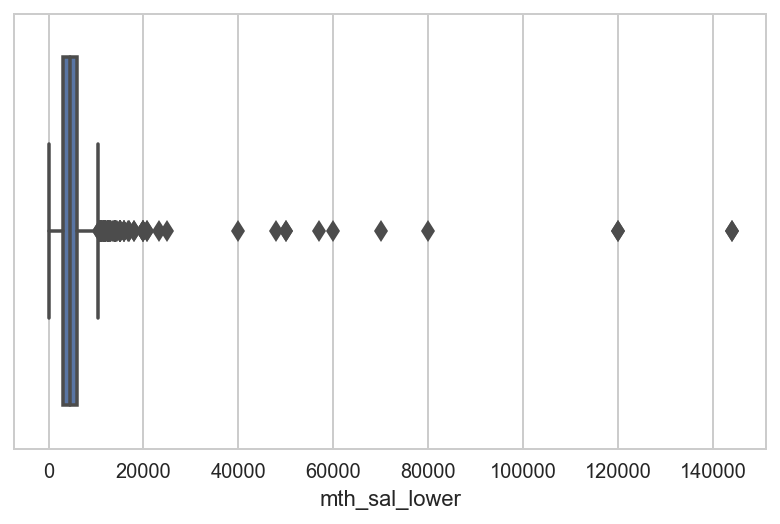

In [12]:
# explore lower salary bound for dataset

sns.set(rc={'figure.figsize':(6,4)},style='whitegrid')
ax = sns.boxplot(x=df['mth_sal_lower'],orient='h',fliersize=8)

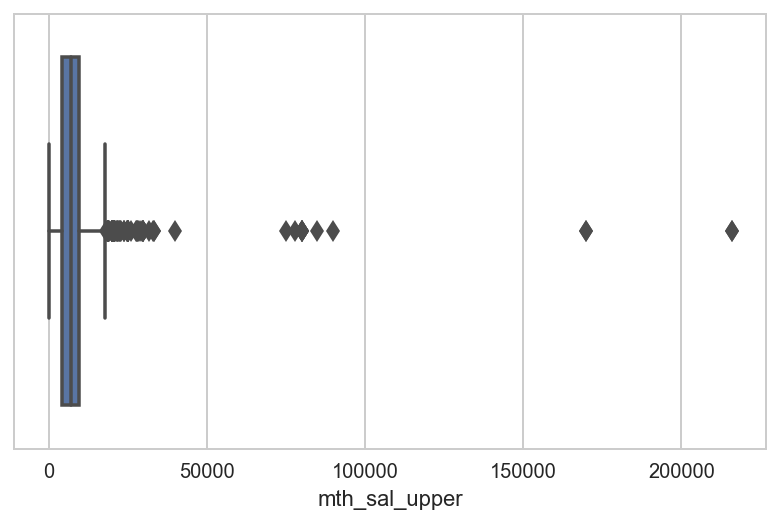

In [13]:
# explore higher salary bound for dataset

sns.set(rc={'figure.figsize':(6,4)},style='whitegrid')
ax = sns.boxplot(x=df['mth_sal_upper'],orient='h',fliersize=8)

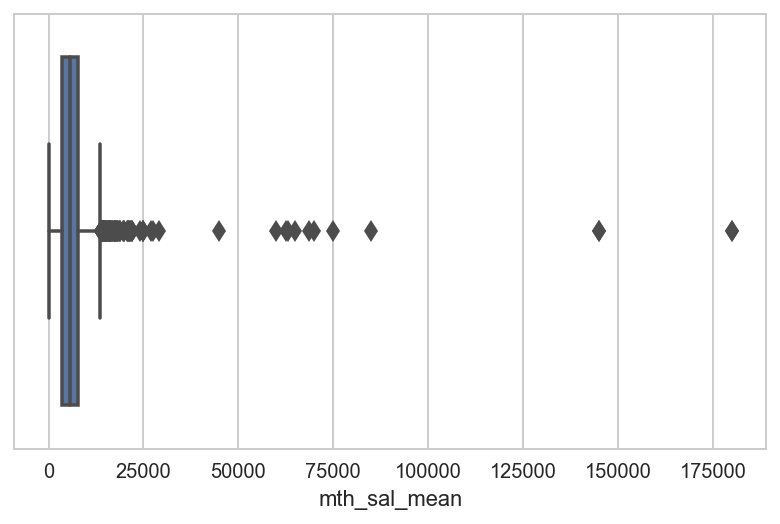

In [14]:
# explore mean salary level for dataset

sns.set(rc={'figure.figsize':(6,4)},style='whitegrid')
ax = sns.boxplot(x=df['mth_sal_mean'],orient='h',fliersize=8)

In [15]:
## examine outlier jobs

df.sort_values('mth_sal_mean',ascending=False).head(30)

,url,company_name,job_title,location,employment_type,seniority,job_category,salary_range,salary_freq,roles & responsibilities,requirements,mth_sal_lower,mth_sal_upper,mth_sal_mean
2097,https://www.mycareersfuture.sg/job/head-sso-si...,six financial information singapore pte. ltd.,head of sso apac,"suntec tower two, 9 temasek boulevard 038989",full time,middle management,"banking and finance, others",144000-216000,monthly,the sso group provides business support servic...,main duties 1 a key positive aspect of the six...,144000.000000,216000.000000,180000.000000
3774,https://www.mycareersfuture.sg/job/head-sso-si...,six financial information singapore pte. ltd.,head of sso apac,"suntec tower two, 9 temasek boulevard 038989",full time,middle management,"banking and finance, others",144000-216000,monthly,the sso group provides business support servic...,main duties 1 a key positive aspect of the six...,144000.000000,216000.000000,180000.000000
2043,https://www.mycareersfuture.sg/job/senior-sale...,six financial information singapore pte. ltd.,senior sales manager,"suntec tower two, 9 temasek boulevard 038989",full time,middle management,banking and finance,120000-170000,monthly,the new position is available in our singapore...,candidates should have a backgroud in selling ...,120000.000000,170000.000000,145000.000000
3738,https://www.mycareersfuture.sg/job/senior-sale...,six financial information singapore pte. ltd.,senior sales manager,"suntec tower two, 9 temasek boulevard 038989",full time,middle management,"banking and finance, others",120000-170000,monthly,the new position is available in our singapore...,candidates should have a backgroud in selling ...,120000.000000,170000.000000,145000.000000
495,https://www.mycareersfuture.sg/job/sr-clinical...,inc research cro singapore pte. ltd.,sr clinical research associate,137 telok ayer street 068602,"permanent, full time","professional, executive, senior executive","environment / health , healthcare / pharmaceu...",80000-90000,monthly,the senior clinical research associate i sr cr...,requirements babs degree in sciencehealth care...,80000.000000,90000.000000,85000.000000
503,https://www.mycareersfuture.sg/job/sr-site-sta...,inc research cro singapore pte. ltd.,sr site startup regulatory specialist,137 telok ayer street 068602,"permanent, full time","professional, senior executive","environment / health , healthcare / pharmaceu...",70000-80000,monthly,performs assigned activities within the countr...,requirements babs degree in the sciencehealt...,70000.000000,80000.000000,75000.000000
2057,https://www.mycareersfuture.sg/job/research-en...,company undisclosed,research engineer,none,full time,fresh/entry level,information technology,60000-80000,monthly,company description securing the software ...,required skills bsms in computer science or r...,60000.000000,80000.000000,70000.000000
4193,https://www.mycareersfuture.sg/job/new-grad-se...,visa worldwide pte. limited,new grad senior software engineer masters degree,71 robinson road 068895,full time,fresh/entry level,information technology,57000-80000,monthly,common purpose uncommon opportunity everyone a...,so what are we looking for in a new grad softw...,57000.000000,80000.000000,68500.000000
1608,https://www.mycareersfuture.sg/job/senior-asso...,ihs markit asia pte. ltd.,senior associate research and analysis korean ...,none,"permanent, full time",senior executive,banking and finance,50000-80000,monthly,department overview ihs markits dividend forec...,education and experience undergraduate degr...,50000.000000,80000.000000,65000.000000
4397,https://www.mycareersfuture.sg/job/research-fe...,national university of singapore,research fellow,21 lower kent ridge road 119077,full time,non-executive,others,48000-78000,monthly,the research fellow will be expected to work o...,qualifications phd in either epidemiology psy...,48000.000000,78000.000000,63000.000000


In [16]:
## remove jobs with mean sal > 30,000

df = df[df['mth_sal_mean']<30000]
df.shape

(4078, 14)

<div class='alert alert-danger'>

### Reduce dataset dimensions

- keep only job titles containing **data** and **business**
- visualize distribution of mean salary level for reduced dataset
- evaluate outliers for mean salary level in reduced dataset

In [17]:
## keep only job titles containing data and business

df1a = df[df['job_title'].str.contains('data',regex=True)]
df1b = df[df['job_title'].str.contains('business',regex=True)]

df1 = pd.concat([df1a,df1b],axis=0)
df1.shape

(643, 14)

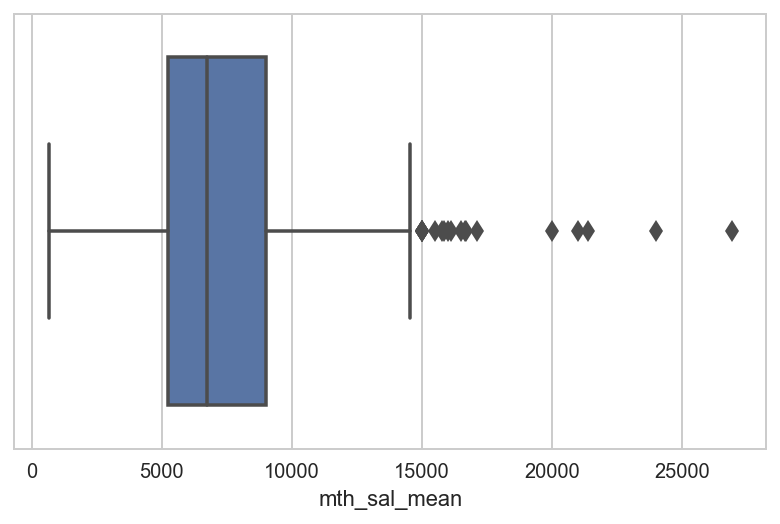

In [18]:
# explore mean salary level for reduced dataset

sns.set(rc={'figure.figsize':(6,4)},style='whitegrid')
ax = sns.boxplot(x=df1['mth_sal_mean'],orient='h',fliersize=8)

In [19]:
## examine outlier jobs

df1.sort_values('mth_sal_mean',ascending=False).head()

,url,company_name,job_title,location,employment_type,seniority,job_category,salary_range,salary_freq,roles & responsibilities,requirements,mth_sal_lower,mth_sal_upper,mth_sal_mean
684,https://www.mycareersfuture.sg/job/data-scient...,nomura singapore limited,data scientist information technology,"marina bay financial centre, 10 marina bouleva...",full time,professional,banking and finance,20800-33000,monthly,nomura overview nomura is an asiabased finan...,key experience skills strong academic backg...,20800.0,33000.0,26900.0
1319,https://www.mycareersfuture.sg/job/vp-data-str...,mastercard asia/pacific pte. ltd.,vp data strategy global data programs,"duo tower, 3 fraser street 189352",permanent,middle management,consulting,18000-30000,monthly,overview the vp data strategy global data pro...,all about you \t proven record of deliverin...,18000.0,30000.0,24000.0
2063,https://www.mycareersfuture.sg/job/head-busine...,google asia pacific pte. ltd.,head of business development google cloud apig...,"marina bay financial centre, 8 marina boulevar...",full time,senior executive,sales / retail,14250-28500,monthly,company overview google is not a conventional ...,minimum qualifications babs degree or equival...,14250.0,28500.0,21375.0
1057,https://www.mycareersfuture.sg/job/business-un...,smith & nephew pte. limited,business unit director,"singapore land tower, 50 raffles place 048623",full time,middle management,"marketing / public relations , sales / retail",17000-25000,monthly,in charge of developing the commercial strate...,bachelors degree and 10 years experience in s...,17000.0,25000.0,21000.0
1140,https://www.mycareersfuture.sg/job/big-data-co...,amazon web services singapore private limited,big data consultant,"aia tower, 1 robinson road 048542","permanent, full time",professional,information technology,15000-25000,monthly,are you an experienced data warehouse and big ...,basic qualifications 5 years of experience in...,15000.0,25000.0,20000.0


<div class='alert alert-danger'>
- <font color=blue>outliers for mean salary level in reduced dataset seem reasonable given job title/seniority</font>

### Feature engineering 2: 
- Create target variable (1 if salary level above median, 0 if otherwise)

In [20]:
sal_med = df1['mth_sal_mean'].median()
sal_mean = df1['mth_sal_mean'].mean()

print('Median salary:', sal_med)
print('Mean salary:', sal_mean)

Median salary: 6750.0
Mean salary: 7313.824002073614


In [21]:
## classify salary level of job as 1 if above median, 0 otherwise

sal_cat= []

for x in df1['mth_sal_mean'].values:
    if x > sal_med:
        sal_cat.append(1)
    else:
        sal_cat.append(0)

df1['salary_level'] = sal_cat

In [22]:
## check if class imbalance present in target variable

df1['salary_level'].value_counts()

0    328
1    315
Name: salary_level, dtype: int64

<div class='alert alert-danger'>

### Feature engineering 3:

i) extract postal code from location


ii) extract postal sector from each postal code (first 2 digits)


iii) assign relevant region to each postal sector (<font color=blue>based on urban planning subdivisions indicated by the Urban Redevelopment Authority of Singapore</font>)


iv) mark rows with no location as 'unknown'

In [23]:
## extracting postal code from location

df1['postal_code'] = df1['location'].str.extract(r'(\d{6})',expand=True)

In [24]:
## assigning postal code to postal sector

df1['postal_sector'] = df1['postal_code'].str.extract(r'^(\d{2})',\
                                                      expand=True)

In [25]:
## feature engineering: region for each postal sector

CBD = ['01','02','03','04','05','06','07','08','17','18','19']

Central = ['09','10','14','15','16','20','21','22','23','24','25','26',\
           '27','28','29','30','31','32','33','34','35','36','37','38',\
           '39','40','41','42','43','44','45','77','78']

East = ['46','47','48','49','50','51','52','81']

North = ['69','70','71','72','73','75','76']

West = ['11','12','13','58','59','60','61','62','63','64','65','66',\
        '67','68']

NorthEast = ['53','54','55','56','57','79','80','82']

df1['region'] = df1['postal_sector']

for i in CBD:
    df1.loc[df1['postal_sector'] == i, 'region'] = df1.\
loc[df1['postal_sector'] == i, 'region'].map(lambda x:x.\
                                             replace(i,'CBD'))
for i in Central:
    df1.loc[df1['postal_sector'] == i, 'region'] = df1.\
loc[df1['postal_sector'] == i, 'region'].map(lambda x:x.\
                                             replace(i,'Central'))
for i in East:
    df1.loc[df1['postal_sector'] == i, 'region'] = df1.\
loc[df1['postal_sector'] == i, 'region'].map(lambda x:x.\
                                             replace(i,'East'))
for i in North:
    df1.loc[df1['postal_sector'] == i, 'region'] = df1.\
loc[df1['postal_sector'] == i, 'region'].map(lambda x:x.\
                                             replace(i,'North'))
for i in West:
    df1.loc[df1['postal_sector'] == i, 'region'] = df1.\
loc[df1['postal_sector'] == i, 'region'].map(lambda x:x.\
                                             replace(i,'West'))
for i in NorthEast:
    df1.loc[df1['postal_sector'] == i, 'region'] = df1.\
loc[df1['postal_sector'] == i, 'region'].map(lambda x:x.\
                                             replace(i,'NorthEast'))

In [26]:
## fill null values with no location

for c in ['postal_code','postal_sector','region']:
    df1[c].fillna(value='unknown',inplace=True)

<div class='alert alert-danger'>

### Create dummy columns for categorical features

In [27]:
dummies = pd.get_dummies(df1['region'])
dummies.drop(columns='unknown',inplace=True)

categ = ['company_name','job_title','employment_type','seniority',\
         'job_category']

for i in categ:
    dummies1 = pd.get_dummies(df1[i],prefix='{}_'.format(i),\
                             drop_first=True)
    dummies = pd.concat([dummies,dummies1],axis=1)

print(dummies.shape)
dummies.head(10)

(643, 871)


CBD  Central  East  North  NorthEast  West  \
0     0        0     0      0          0     1   
1     1        0     0      0          0     0   
2     1        0     0      0          0     0   
3     0        0     1      0          0     0   
4     1        0     0      0          0     0   
5     1        0     0      0          0     0   
6     1        0     0      0          0     0   
8     0        1     0      0          0     0   
9     1        0     0      0          0     0   
10    1        0     0      0          0     0   

    company_name__a*star research entities  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
5                                        0   
6                                        0   
8                                        0   
9                                        0   
10                                       0   

    company_name__abakus (asia pacific) pte. ltd.  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
5                                               0   
6                                               0   
8                                               0   
9                                               0   
10                                              0   

    company_name__accion labs pte. ltd.  \
0                                     0   
1                                     0   
2                                     0   
3                                     0   
4                                     0   
5                                     0   
6                                     0   
8                                     0   
9                                     0   
10                                    0   

    company_name__acetech manpower consultancy pte ltd  \
0                                                   0    
1                                                   0    
2                                                   0    
3                                                   0    
4                                                   0    
5                                                   0    
6                                                   0    
8                                                   0    
9                                                   0    
10                                                  0    

    company_name__activate interactive pte ltd  company_name__addstones sas  \
0                                            0                            0   
1                                            0                            0   
2                                            0                            0   
3                                            0                            0   
4                                            0                            0   
5                                            0                            0   
6                                            0                            1   
8                                            0                            0   
9                                            0                            0   
10                                           0                            0   

    company_name__adecco personnel pte ltd  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   
5                                        0   
6                                        0   
8          

<div class='alert alert-danger'>

### Feature selection

- use `SelectKBest` method to select the top 10 highest scoring features
- use `f_classif` and `chi2` functions to evaluate what makes a feature the best


The F-test is <font color=blue>the explained variance divided by the unexplained variance</font>. If the explained variance is much greater than the unexplained variance, the result will be high numbers.
- what are the top 10 features using `f_classif`?

The `chi2` goodness of fit compares the observed sample distribution with the expected probability distribution. It is <font color=blue>the sum of the difference squared between observed and expected values, divided by the expected value</font>.
- what are the top 10 features using `chi2`?

*note: refer to Titanic lab example*

In [28]:
# build the selector (one with each score type)
skb_f = SelectKBest(f_classif, k=10)
skb_chi2 = SelectKBest(chi2, k=10)

# define target and predictor variables
X = dummies[dummies.columns]
y = df1['salary_level'].values

# train selector on the data
skb_f.fit(X,y)
skb_chi2.fit(X,y)

# evaluate results (sort based on f_classif)
kbest = pd.DataFrame([list(dummies.columns), list(skb_f.scores_),\
                      list(skb_chi2.scores_)],\
                     index=['feature','f_classif','chi2 score']).T

k1 = kbest.sort_values('f_classif',ascending=False)
k1.head(10)

,feature,f_classif,chi2 score
82,company_name__dbs bank ltd.,25.1244,22.6681
789,seniority__senior management,21.6973,19.9719
0,CBD,21.2137,10.2511
767,seniority__manager,18.8565,16.2887
782,seniority__professional,15.637,11.7163
738,"employment_type__contract, full time",14.1343,12.9017
765,seniority__junior executive,13.405,12.6183
758,seniority__fresh/entry level,10.1558,9.81022
466,job_title__data engineer,9.85157,9.29377
805,job_category__banking and finance,9.69208,8.83276


In [29]:
# evaluate results (sort based on chi2)

k2 = kbest.sort_values('chi2 score',ascending=False)
k2.head(10)

,feature,f_classif,chi2 score
82,company_name__dbs bank ltd.,25.1244,22.6681
789,seniority__senior management,21.6973,19.9719
767,seniority__manager,18.8565,16.2887
738,"employment_type__contract, full time",14.1343,12.9017
765,seniority__junior executive,13.405,12.6183
782,seniority__professional,15.637,11.7163
0,CBD,21.2137,10.2511
758,seniority__fresh/entry level,10.1558,9.81022
466,job_title__data engineer,9.85157,9.29377
805,job_category__banking and finance,9.69208,8.83276


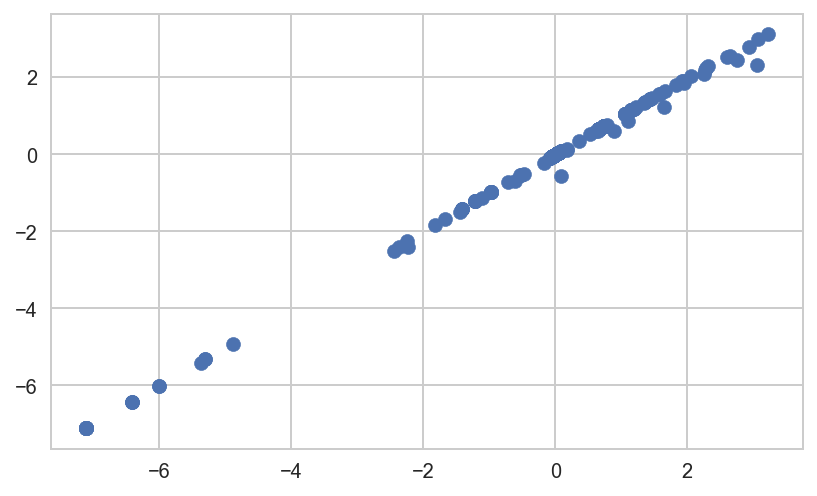

In [30]:
# visualize features ranking

plt.scatter([np.log(x) for x in kbest['f_classif']],
            [np.log(x) for x in kbest['chi2 score']])

<div class='alert alert-danger'>

Since top 10 features selected using `f_classif` and `chi2` are similar, we will use these features for further modeling.
- define predictor variables using top 10 features
- stratified train-test split
- scale the features

In [31]:
## top 10 features

a = k1['feature'].values[:10]
a

array(['company_name__dbs bank ltd.', 'seniority__senior management',
       'CBD', 'seniority__manager', 'seniority__professional',
       'employment_type__contract, full time',
       'seniority__junior executive', 'seniority__fresh/entry level',
       'job_title__data engineer', 'job_category__banking and finance'],
      dtype=object)

In [32]:
## define predictor variables using the top 10 features

X = dummies[a]
y = df1['salary_level'].values

In [33]:
## stratified train-test split & feature scaling

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,\
                                                    test_size=0.2)

ss = StandardScaler()

Xs_train = ss.fit_transform(X_train)
Xs_test = ss.transform(X_test)

<div class='alert alert-danger'>

#### Using SVM

In [34]:
## using SVM 
# (refer to Day29_SVM_lab_solution_code)

for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(kernel=kernel, degree=3)
    scores = cross_val_score(svm, Xs_train, y_train, cv=5,\
                             scoring='roc_auc')
    sm = scores.mean()
    ss = scores.std()
    print("{} - Average score: {:0.3} +/- {:0.3}".format(kernel,sm, ss))

linear - Average score: 0.722 +/- 0.0252
poly - Average score: 0.732 +/- 0.0407
rbf - Average score: 0.67 +/- 0.0207
sigmoid - Average score: 0.696 +/- 0.0444


In [35]:
def print_cm_cr(y_true, y_pred):
    """prints the confusion matrix and the classification report"""
    confusion = pd.crosstab(y_true, 
                            y_pred, 
                            rownames=['Actual'], 
                            colnames=['Predicted'], 
                            margins=True)
    print(confusion)
    print('')
    print(classification_report(y_true, y_pred))

In [36]:
## choose kernel with best cross_val_score

svm = SVC(kernel='linear',probability=True)

svm.fit(Xs_train, y_train)
y_pred_svm = svm.predict(Xs_test)
print_cm_cr(y_test, y_pred_svm)

Predicted   0   1  All
Actual                
0          52  14   66
1          29  34   63
All        81  48  129

              precision    recall  f1-score   support

           0       0.64      0.79      0.71        66
           1       0.71      0.54      0.61        63

   micro avg       0.67      0.67      0.67       129
   macro avg       0.68      0.66      0.66       129
weighted avg       0.67      0.67      0.66       129



SVM AUC: 0.73003848003848


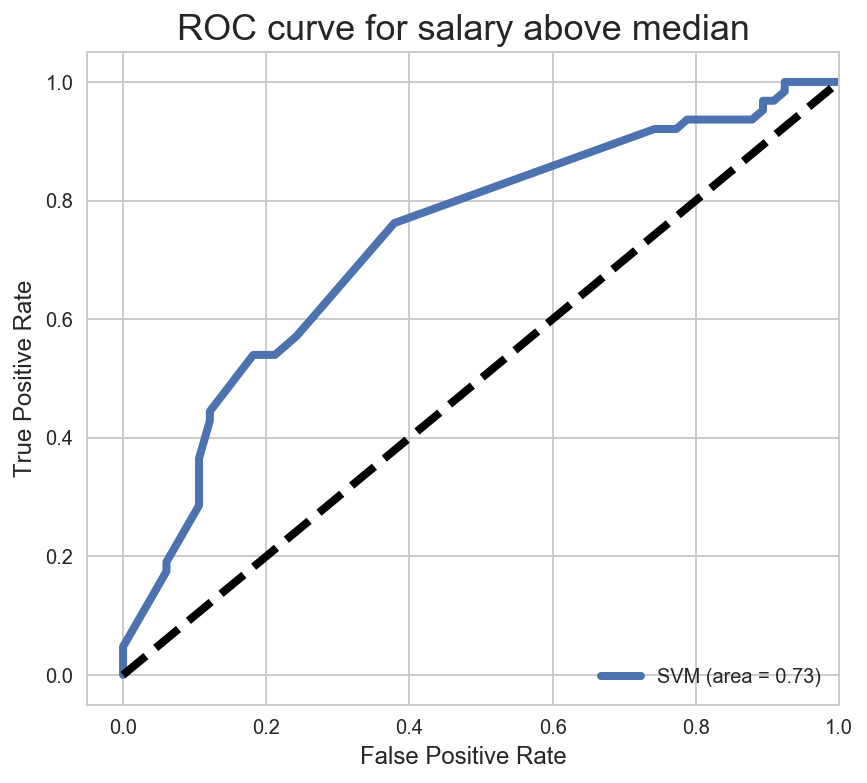

In [37]:
## evaluate model using ROC curve 
# (refer to Day22_evaluating_classifiers_confusion_matrix)

yhat = svm.predict(Xs_test)
yhat_pp_svm = svm.predict_proba(Xs_test)

fpr_svm, tpr_svm, _ = roc_curve(y_test, yhat_pp_svm[:,1])
roc_auc_svm = auc(fpr_svm, tpr_svm)

print('SVM AUC:', roc_auc_svm)

plt.figure(figsize=[6,6])
plt.plot(fpr_svm,tpr_svm,label='SVM (area = %0.2f)' % roc_auc_svm,\
         linewidth=4) # plotting ROC curve for SVM
plt.plot([0, 1], [0, 1], 'k--', linewidth=4) # plotting baseline
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for salary above median', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<div class='alert alert-danger'>

#### Using Logistic Regression with GridSearch

In [38]:
## use GridSearchCV to find optimum parameters

logr_parameters = {
    'penalty':['l1','l2'],
    'solver':['liblinear'],
    'C':np.linspace(1, 25, 25)}

logr_gridsearcher = GridSearchCV(LogisticRegression(), logr_parameters,\
                                 verbose=1)

logr_result = logr_gridsearcher.fit(Xs_train, y_train)

print('Best mean cross-validated score achieved:',\
      logr_result.best_score_)
print('Best parameters:', logr_result.best_params_)

logrbest = logr_result.best_estimator_
print('Logistic Regression Classification score:',\
      logrbest.score(Xs_test, y_test))

baseline = 1 - np.mean(y_train)
print('Baseline:', baseline)

yhat = logrbest.predict(Xs_test)
yhat_pp_logr = logrbest.predict_proba(Xs_test)

confusion_matrix(y_test, yhat)

print(classification_report(y_test, yhat))

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.6906614785992218
Best parameters: {'C': 1.0, 'penalty': 'l1', 'solver': 'liblinear'}
Logistic Regression Classification score: 0.6821705426356589
Baseline: 0.5097276264591439
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        66
           1       0.72      0.57      0.64        63

   micro avg       0.68      0.68      0.68       129
   macro avg       0.69      0.68      0.68       129
weighted avg       0.69      0.68      0.68       129



[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed:    0.3s finished


Logistic Regression Classification AUC: 0.7536075036075037


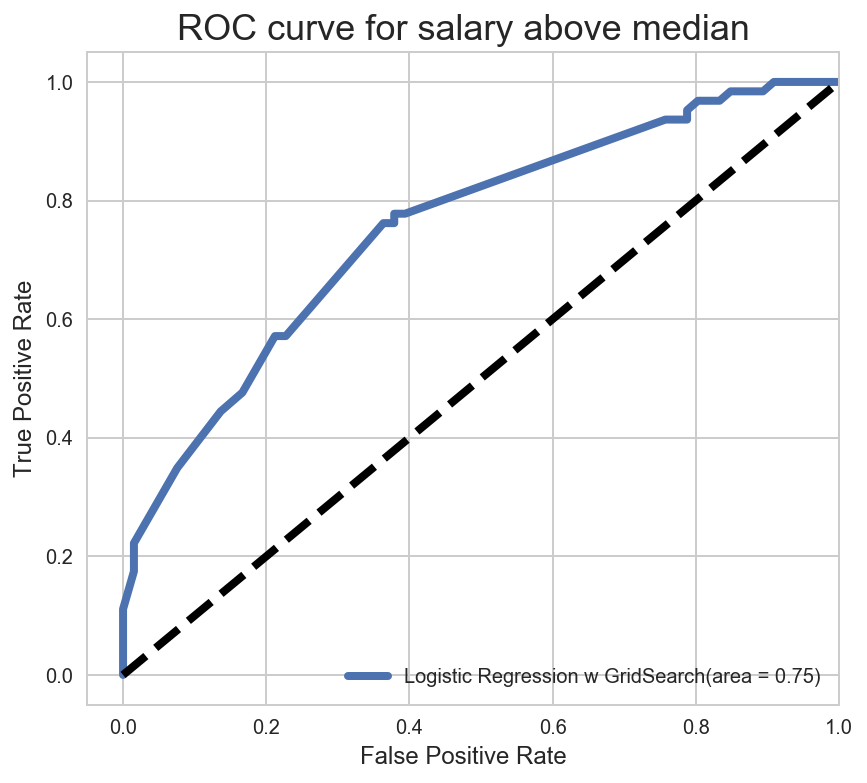

In [39]:
# evaluate model using ROC curve

fpr_logr, tpr_logr, _ = roc_curve(y_test, yhat_pp_logr[:,1])
roc_auc_logr = auc(fpr_logr, tpr_logr)

print('Logistic Regression Classification AUC:', roc_auc_logr)

plt.figure(figsize=[6,6])
plt.plot(fpr_logr,tpr_logr,label='Logistic Regression w GridSearch\
(area = %0.2f)'%roc_auc_logr,linewidth=4) # plotting ROC curve for logreg
plt.plot([0, 1], [0, 1], 'k--', linewidth=4) # plotting baseline
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for salary above median', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<div class='alert alert-danger'>

#### Using Random Forest Classifier with GridSearch

In [40]:
## use GridSearchCV to find optimum parameters

ranf_parameters = {
    'n_estimators': [100,200],
    'max_features': [None, 'auto','log2',2,3,4,5],
    'max_depth' : [None,2,3,4],
    'min_samples_split' : [10,15,20,25,30],
    'criterion' :['gini', 'entropy']}

ranf_gridsearcher = GridSearchCV(RandomForestClassifier(),\
                                 ranf_parameters, verbose=1)

ranf_result = ranf_gridsearcher.fit(Xs_train, y_train)

print('Best mean cross-validated score achieved:',\
      ranf_result.best_score_)
print('Best parameters:', ranf_result.best_params_)

ranfbest = ranf_result.best_estimator_
print('Random Forest Classification score:',\
      ranfbest.score(Xs_test, y_test))

baseline = 1 - np.mean(y_train)
print('Baseline:', baseline)

yhat = ranfbest.predict(Xs_test)
yhat_pp_ranf = ranfbest.predict_proba(Xs_test)

confusion_matrix(y_test, yhat)

print(classification_report(y_test, yhat))

Fitting 3 folds for each of 560 candidates, totalling 1680 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Best mean cross-validated score achieved: 0.6964980544747081
Best parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 2, 'min_samples_split': 30, 'n_estimators': 100}
Random Forest Classification score: 0.6666666666666666
Baseline: 0.5097276264591439
              precision    recall  f1-score   support

           0       0.65      0.76      0.70        66
           1       0.69      0.57      0.63        63

   micro avg       0.67      0.67      0.67       129
   macro avg       0.67      0.66      0.66       129
weighted avg       0.67      0.67      0.66       129



[Parallel(n_jobs=1)]: Done 1680 out of 1680 | elapsed:  3.9min finished


Random Forest AUC: 0.7343674843674843


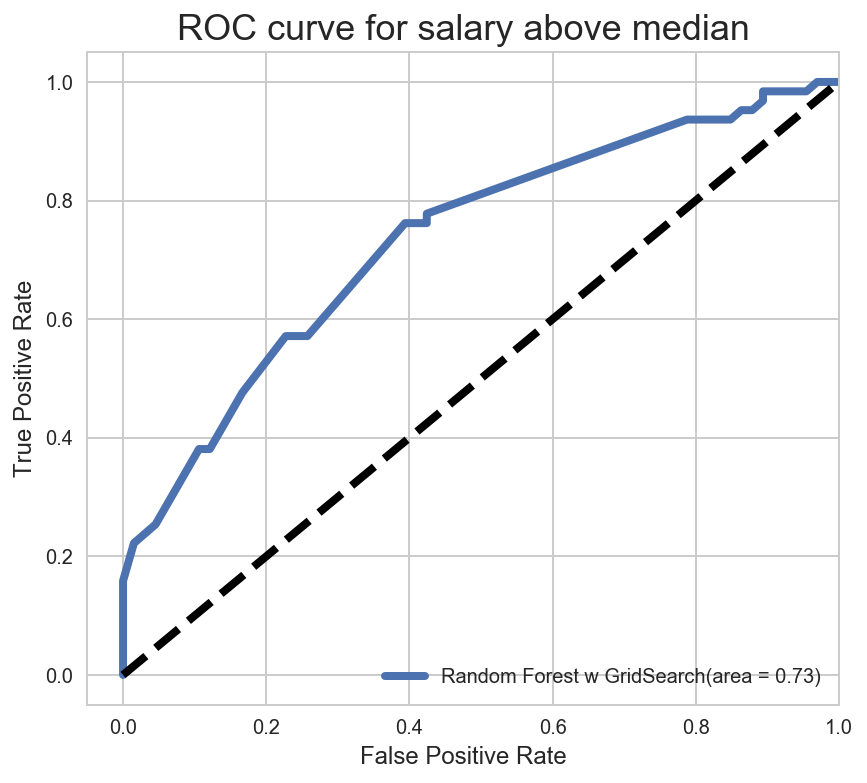

In [41]:
# evaluate model using ROC curve

fpr_ranf, tpr_ranf, _ = roc_curve(y_test, yhat_pp_ranf[:,1])
roc_auc_ranf = auc(fpr_ranf, tpr_ranf)

print('Random Forest AUC:', roc_auc_ranf)

plt.figure(figsize=[6,6])
plt.plot(fpr_ranf,tpr_ranf,label='Random Forest w GridSearch\
(area = %0.2f)'%roc_auc_ranf,linewidth=4) # plotting ROC curve for RF
plt.plot([0, 1], [0, 1], 'k--', linewidth=4) # plotting baseline
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for salary above median', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<div class='alert alert-danger'>

#### Using Bagging with Decision Tree

In [42]:
DT = DecisionTreeClassifier(max_depth=15)

bagger = BaggingClassifier(base_estimator=DT, max_samples=0.5,\
                           max_features=0.5, n_estimators=30)

print('DT score:\t', cross_val_score(DT, Xs_train, y_train, cv=10,\
                                      n_jobs=1).mean())
print('Bagging score:\t', cross_val_score(bagger, Xs_train, y_train,\
                                          cv=10,n_jobs=1).mean())

bagger.fit(Xs_train,y_train)

baseline = 1 - np.mean(y_train)
print('Baseline:', baseline)

yhat = bagger.predict(Xs_test)
yhat_pp_bagg = bagger.predict_proba(Xs_test)

confusion_matrix(y_test, yhat)

print(classification_report(y_test, yhat))

DT score:	 0.6847206807251202
Bagging score:	 0.6869774324824268
Baseline: 0.5097276264591439
              precision    recall  f1-score   support

           0       0.66      0.79      0.72        66
           1       0.72      0.57      0.64        63

   micro avg       0.68      0.68      0.68       129
   macro avg       0.69      0.68      0.68       129
weighted avg       0.69      0.68      0.68       129



Bagging AUC: 0.7353294853294853


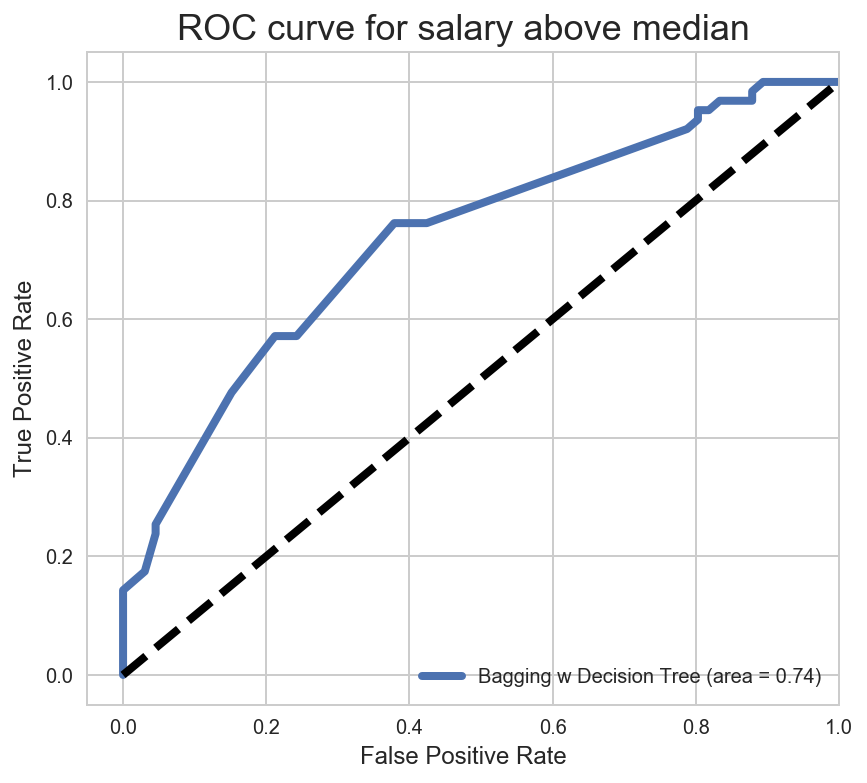

In [43]:
# evaluate model using ROC curve

fpr_bagg, tpr_bagg, _ = roc_curve(y_test, yhat_pp_bagg[:,1])
roc_auc_bagg = auc(fpr_bagg, tpr_bagg)

print('Bagging AUC:', roc_auc_bagg)

plt.figure(figsize=[6,6])
plt.plot(fpr_bagg,tpr_bagg,label='Bagging w Decision Tree (area = %0.2f)'\
         %roc_auc_bagg,linewidth=4) # plotting ROC curve for bagging
plt.plot([0, 1], [0, 1], 'k--', linewidth=4) # plotting baseline
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC curve for salary above median', fontsize=18)
plt.legend(loc="lower right")
plt.show()

<div class='alert alert-danger'>

#### Comparison of classification models:

Conclusion: `Logistic Regression with GridSearch` is the best model.


The <font color=blue>top 10 features that influence salary</font> are:

- `company_name__dbs bank ltd.`
- `seniority__manager`
- `seniority__senior management`
- `seniority__professional`
- `CBD`
- `employment_type__contract`
- `full time`
- `seniority__junior executive`
- `seniority__fresh/entry level`
- `job_title__data engineer`

In [44]:
print('SVM AUC:', roc_auc_svm)
print('Logistic Regression Classification AUC:', roc_auc_logr)
print('Random Forest AUC:', roc_auc_ranf)
print('Bagging AUC:', roc_auc_bagg)

SVM AUC: 0.73003848003848
Logistic Regression Classification AUC: 0.7536075036075037
Random Forest AUC: 0.7343674843674843
Bagging AUC: 0.7353294853294853


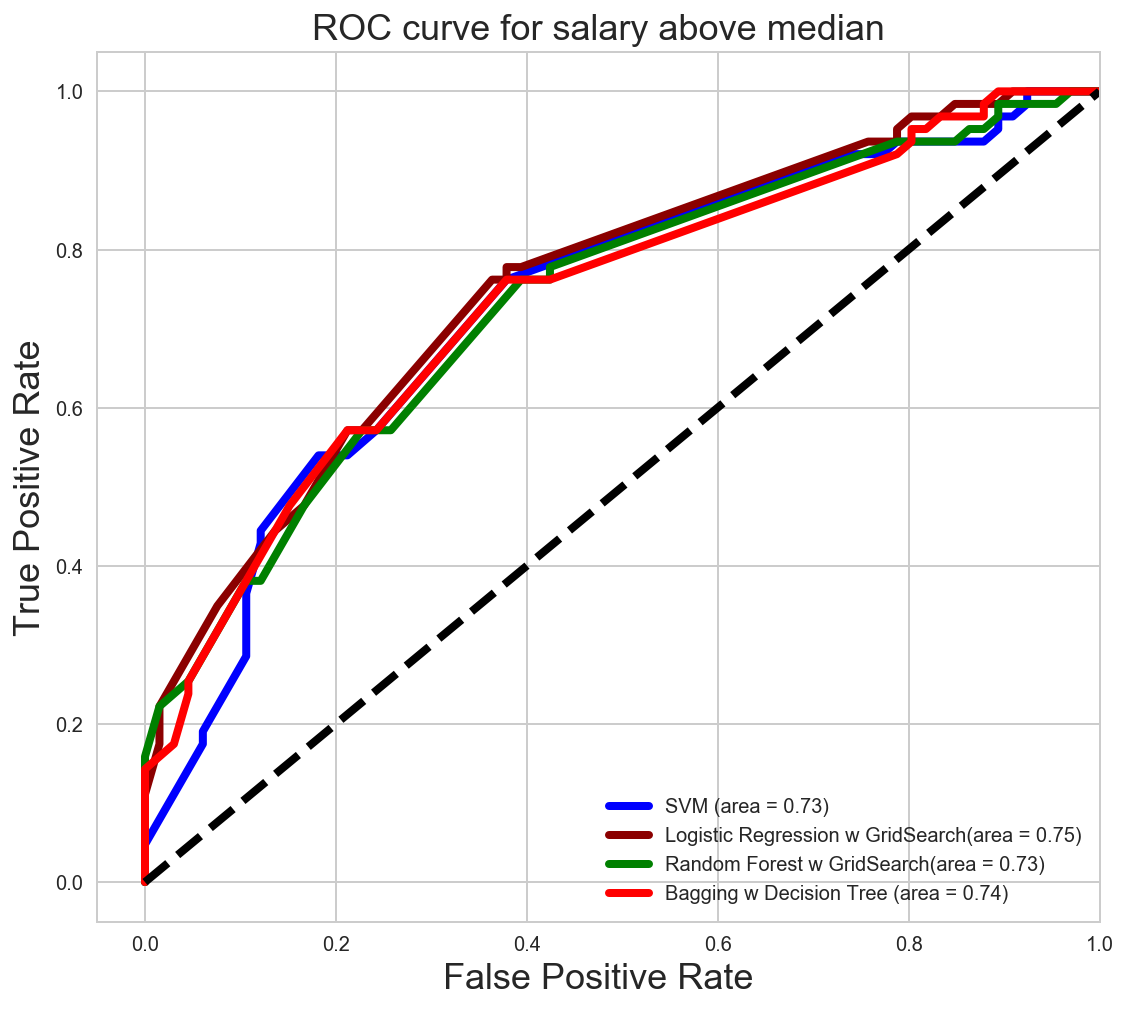

In [45]:
## plotting the 4 models together
plt.figure(figsize=[8,8])
plt.plot(fpr_svm, tpr_svm, label='SVM (area = %0.2f)' % roc_auc_svm,\
         linewidth=4, color='blue')
plt.plot(fpr_logr,tpr_logr,label='Logistic Regression w GridSearch\
(area = %0.2f)'%roc_auc_logr,linewidth=4, color='darkred')
plt.plot(fpr_ranf,tpr_ranf,label='Random Forest w GridSearch\
(area = %0.2f)'%roc_auc_ranf,linewidth=4, color='green')
plt.plot(fpr_bagg,tpr_bagg,label='Bagging w Decision Tree (area = %0.2f)'\
         %roc_auc_bagg,linewidth=4, color='red')
plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC curve for salary above median', fontsize=18)
plt.legend(loc="lower right")
plt.show()

---
### Question 2 - Factors that distinguish job category

Using the job postings you scraped for part 1, <font color=red>identify features in the data</font> related to job postings that <font color=red>can distinguish job titles from each other</font>. There are a variety of interesting ways you can frame the target variable, for example:
- What components of a job posting distinguish data scientists from other data jobs?
- What features are important for distinguishing junior vs. senior positions?
- Do the requirements for titles vary significantly with industry (e.g. healthcare vs. government)?

You may end up making multiple classification models to tackle different questions. Be sure to clearly explain your hypotheses and framing, any feature engineering, and what your target variables are. The type of classification model you choose is up to you. Be sure to interpret your results and evaluate your models' performance.

<div class='alert alert-warning'>

### Objective: find out if the requirements for titles vary significantly with industry

We will apply NLP techniques on a reduced dataset (top 5 most popular job titles) to determine what are the requirements for titles and if these requirements vary with industry. We will vectorize the requirements feature.

In [46]:
df2 = df1.copy(deep=True)
df2.head()

,url,company_name,job_title,location,employment_type,seniority,job_category,salary_range,salary_freq,roles & responsibilities,requirements,mth_sal_lower,mth_sal_upper,mth_sal_mean,salary_level,postal_code,postal_sector,region
0,https://www.mycareersfuture.sg/job/senior-staf...,ge measurement and control (singapore) pte. ltd.,senior staff data engineer,"the metropolis, 11 north buona vista drive 138589",permanent,senior executive,information technology,8000-10000,monthly,role summarypurpose this role will be part of ...,qualificationsrequirements bachelorsmasters d...,8000.0,10000.0,9000.0,1,138589,13,West
1,https://www.mycareersfuture.sg/job/data-engine...,morgan mckinley pte. ltd.,data engineer,"one raffles place, 1 raffles place 048616",permanent,senior executive,information technology,3300-6300,monthly,you will participate in constructing internat...,1 major in computer science mathematics stati...,3300.0,6300.0,4800.0,0,048616,04,CBD
2,https://www.mycareersfuture.sg/job/data-engine...,affable technologies pte. ltd.,data engineer,"high street centre, 1 north bridge road 179094",full time,professional,information technology,4000-7000,monthly,affable is a venturebacked startup in singapor...,data mining big data data warehousing data scr...,4000.0,7000.0,5500.0,0,179094,17,CBD
3,https://www.mycareersfuture.sg/job/data-intern...,smartkarma innovations pte. ltd.,data intern,"the signature, 51 changi business park central...",internship,"fresh/entry level, executive","admin / secretarial, banking and finance",1000-1000,monthly,important please complete the smartkarma data ...,required skills great attention to detail ...,1000.0,1000.0,1000.0,0,486066,48,East
4,https://www.mycareersfuture.sg/job/big-data-en...,ernst & young advisory pte. ltd.,big data engineer financial services,1 raffles quay 048583,full time,manager,"consulting , banking and finance, information ...",6800-13600,monthly,we are the only professional services organisa...,skills and attributes for success leverage te...,6800.0,13600.0,10200.0,1,048583,04,CBD


<div class='alert alert-danger'>

#### Reduce dataset dimensions
- select top 5 most popular job titles to analyze
- observe and select the main job categories for these 5 titles
- encode each category as a binary classification (some jobs may belong to multiple categories)

In [47]:
## top 5 most popular job titles

df2['job_title'].value_counts().head()

data scientist                  50
data engineer                   29
business analyst                26
data analyst                    17
business development manager    10
Name: job_title, dtype: int64

In [48]:
## reducing dataset to only top 5 most popular job titles

df2a = df2[df2['job_title'].str.contains('data scientist',regex=True)]
df2b = df2[df2['job_title'].str.contains('data engineer',regex=True)]
df2c = df2[df2['job_title'].str.contains('business analyst',regex=True)]
df2d = df2[df2['job_title'].str.contains('data analyst',regex=True)]
df2e = df2[df2['job_title'].str.contains('business development manager',\
                                         regex=True)]

df2 = pd.concat([df2a,df2b,df2c,df2d,df2e],axis=0)
df2.shape

(313, 18)

In [49]:
## categories which the top 5 most popular job titles belong to

df2['job_category'].value_counts().head(10)

information technology                                      156
banking and finance                                          27
engineering                                                  20
others                                                       17
engineering, information technology                          12
banking and finance, information technology                   8
consulting , banking and finance, information technology      7
sales / retail                                                5
consulting                                                    5
information technology, public / civil service                4
Name: job_category, dtype: int64

In [50]:
## dummy coding the 4 main categories

categ1 = []
categ2 = []
categ3 = []
categ4 = []

for x in df2['job_category'].values:
    if 'information technology' in x:
        categ1.append(1)
    else:
        categ1.append(0)
    
    if 'banking and finance' in x:
        categ2.append(1)
    else:
        categ2.append(0)
    
    if 'engineering' in x:
        categ3.append(1)
    else:
        categ3.append(0)
    
    if 'consulting' in x:
        categ4.append(1)
    else:
        categ4.append(0)

df2['category_information_technology'] = categ1
df2['category_banking_and_finance'] = categ2
df2['category_engineering'] = categ3
df2['category_consulting'] = categ4

df2.head(10)

,url,company_name,job_title,location,employment_type,seniority,job_category,salary_range,salary_freq,roles & responsibilities,requirements,mth_sal_lower,mth_sal_upper,mth_sal_mean,salary_level,postal_code,postal_sector,region,category_information_technology,category_banking_and_finance,category_engineering,category_consulting
11,https://www.mycareersfuture.sg/job/data-scient...,lam research singapore pte ltd,data scientist,none,"permanent, full time",professional,engineering,4000-6000,monthly,a technical expert who will work with multidim...,bachelor or masters in data science computer ...,4000.0,6000.0,5000.0,0,unknown,unknown,unknown,0,0,1,0
12,https://www.mycareersfuture.sg/job/senior-data...,lam research singapore pte ltd,senior data scientist,none,"permanent, full time",professional,engineering,8500-12750,monthly,a technical expert who will work with multidim...,bachelor or masters in data science computer ...,8500.0,12750.0,10625.0,1,unknown,unknown,unknown,0,0,1,0
13,https://www.mycareersfuture.sg/job/data-scient...,lam research singapore pte ltd,data scientist,none,"permanent, full time",professional,engineering,6000-9000,monthly,a technical expert who will work with multidim...,bachelor or masters in data science computer ...,6000.0,9000.0,7500.0,1,unknown,unknown,unknown,0,0,1,0
22,https://www.mycareersfuture.sg/job/data-scient...,biofourmis singapore pte. ltd.,data scientist signal processing,"vision exchange, 2 venture drive 608526",full time,executive,information technology,4000-5500,monthly,the candidate uses strong coding skills to hel...,master in biomedical engineering computer sci...,4000.0,5500.0,4750.0,0,608526,60,West,1,0,0,0
254,https://www.mycareersfuture.sg/job/data-scient...,portcast pte. ltd.,data scientist,32 carpenter street 059911,full time,middle management,engineering,2200-6000,monthly,in this role you will be responsible for analy...,comfortable working with large amounts of da...,2200.0,6000.0,4100.0,0,059911,05,CBD,0,0,1,0
261,https://www.mycareersfuture.sg/job/data-scient...,jabil circuit (singapore) pte. ltd.,data scientist intern 6 months,16 tampines industrial crescent 528604,internship,fresh/entry level,"information technology, manufacturing, others",800-1500,monthly,essential duties responsibilities analyse raw...,education experience requirements advanced de...,800.0,1500.0,1150.0,0,528604,52,East,1,0,0,0
478,https://www.mycareersfuture.sg/job/avp-data-sc...,dbs bank ltd.,avp data scientist business analytics consumer...,"marina bay financial centre, 12 marina bouleva...",full time,senior management,information technology,6500-11700,monthly,business function as the leading bank in asia...,masters or equivalent degree in statistics ap...,6500.0,11700.0,9100.0,1,018982,01,CBD,1,0,0,0
480,https://www.mycareersfuture.sg/job/data-scient...,niometrics (pte.) ltd.,data scientist,"parkview square, 600 north bridge road 188778",permanent,professional,information technology,5000-10000,monthly,what we do niometrics captures organises and e...,what we value babs or mams or equivalent expe...,5000.0,10000.0,7500.0,1,188778,18,CBD,1,0,0,0
483,https://www.mycareersfuture.sg/job/lead-data-s...,redmart limited,lead data scientist,"singapore wine vault building, 6 fishery port ...","permanent, full time",professional,"engineering, information technology",7000-14000,monthly,as one of the fastest growing ecommerce and lo...,qualifications deep expertise in search prefe...,7000.0,14000.0,10500.0,1,619747,61,West,1,0,1,0
487,https://www.mycareersfuture.sg/job/senior-staf...,ncs pte. ltd.,senior staff data scientist,none,full time,professional,"engineering, information technology",8000-13000,monthly,work with customers to identify opportunities...,phdmastersbachelors with good honours in comp...,8000.0,13000.0,10500.0,1,unknown,unknown,unknown,1,0,1,0


In [51]:
## drop columns that are not needed

df2.drop(columns=['url','location','employment_type','seniority',\
                  'job_category','salary_range','salary_freq',\
                  'mth_sal_lower','mth_sal_upper','mth_sal_mean',\
                  'salary_level','postal_code','postal_sector',\
                  'region'],inplace=True)
df2.columns

Index(['company_name', 'job_title', 'roles & responsibilities', 'requirements',
       'category_information_technology', 'category_banking_and_finance',
       'category_engineering', 'category_consulting'],
      dtype='object')

In [52]:
print(df2['category_information_technology'].value_counts())
print(df2['category_banking_and_finance'].value_counts())
print(df2['category_engineering'].value_counts())
print(df2['category_consulting'].value_counts())

1    203
0    110
Name: category_information_technology, dtype: int64
0    268
1     45
Name: category_banking_and_finance, dtype: int64
0    272
1     41
Name: category_engineering, dtype: int64
0    294
1     19
Name: category_consulting, dtype: int64


<div class='alert alert-danger'>

- use `CountVectorizer` to convert values in **requirements** column into a matrix of token counts

In [53]:
## apply countvectorizer

cv = CountVectorizer(ngram_range=(2,3), max_features=5000, binary=True,\
                     stop_words='english')
words = cv.fit_transform(df2['requirements'])

In [54]:
print(words.shape)
words = pd.DataFrame(words.todense(),columns=cv.get_feature_names())
words.head()

(313, 5000)


10 years  10 years experience  12 years  12 years experience  15 20  \
0         0                    0         0                    0      0   
1         0                    0         0                    0      0   
2         0                    0         0                    0      0   
3         0                    0         0                    0      0   
4         0                    0         0                    0      0   

   15 20 minutes  20 minutes  20 minutes complete  2020 reality  \
0              0           0                    0             0   
1              0           0                    0             0   
2              0           0                    0             0   
3              0           0                    0             0   
4              0           0                    0             0   

   2020 reality confidently  28 years  28 years experience  35 years  \
0                         0         0                    0         0   
1                         0         0                    0         0   
2                         0         0                    0         0   
3                         0         0                    0         0   
4                         0         0                    0         0   

   35 years experience  610 years  610 years experience  aa experience  \
0                    0          0                     0              0   
1                    0          0                     0              0   
2                    0          0                     0              0   
3                    0          0                     0              0   
4                    0          0                     0              0   

   ab testing  ab testing desired  ability analyze  ability analyze summarize  \
0           0                   0                0                          0   
1           0                   0                0                          0   
2           0                   0                0                          0   
3           0                   0                0                          0   
4           0                   0                0                          0   

   ability articulate  ability build  ability collect  \
0                   0              0                0   
1                   0              0                0   
2                   0              0                0   
3                   0              0                0   
4                   0              0                0   

   ability collect organize  ability communicate  ability communicate clearly  \
0                         0                    0                            0   
1                         0                    0                            0   
2                         0                    0                            0   
3                         0                    0                            0   
4                         0                    0                            0   

   ability communicate complex  ability communicate technical  \
0                            0                              0   
1                            0                              0   
2                            0                              0   
3                            0                              0   
4                            0                              0   

   ability conceptualise  ability conceptualise architect  ability convey  \
0                      0                                0               0   
1                      0                                0               0   
2                      0                                0               0   
3                      0                                0               0   
4                      0                                0               0   

   ability convey information  ability deal  ability deal ambiguity  \
0                           0      

<div class='alert alert-danger'>

#### Find the most likely words for jobs in the `information technology` category

- split data into training and test sets
- build a `BernoulliNB` model to predict if in infotech category from word appearances
- collate probabilities and features

In [55]:
## train test split for category_information_technology

X1_train, X1_test, y1_train, y1_test = train_test_split(words.values,\
        df2['category_information_technology'].values, test_size=0.2)
print(X1_train.shape, y1_train.shape)
print(X1_test.shape, y1_test.shape)

## fit BernoulliNB model on training set

nb1 = BernoulliNB()
nb1.fit(X1_train, y1_train)

nb1_scores = cross_val_score(nb1, X1_train, y1_train, cv=10)
print('Average cross-validated NB score: ',np.mean(nb1_scores))
print('Baseline: ',np.mean(y1_train))

## evaluate model performance on test set (compare to baseline)

print('Model performance on test set: ',nb1.score(X1_test, y1_test))
print('Baseline for test set: ',np.mean(y1_test))

## extract top 10 requirements for Information technology category

feat_1p = nb1.feature_log_prob_
infotech_yes = np.exp(feat_1p[1])
infotech_no = np.exp(feat_1p[0])

feat1_probs = pd.DataFrame({'in InfoTech':infotech_yes,\
                           'not in InfoTech':infotech_no,\
                           'feature':words.columns.values})

feat1_probs['infotech_diff'] = feat1_probs['in InfoTech']\
- feat1_probs['not in InfoTech']

feat1_probs.sort_values('infotech_diff', ascending=False, inplace=True)
info_tech_words = feat1_probs['feature'].values[:10]
feat1_probs.head(10)

(250, 5000) (250,)
(63, 5000) (63,)
Average cross-validated NB score:  0.45520512820512826
Baseline:  0.672
Model performance on test set:  0.6031746031746031
Baseline for test set:  0.5555555555555556


,in InfoTech,not in InfoTech,feature,infotech_diff
813,0.435294,0.273810,computer science,0.161485
2609,0.376471,0.238095,machine learning,0.138375
2035,0.205882,0.107143,good understanding,0.098739
4188,0.117647,0.023810,sql server,0.093838
1011,0.188235,0.095238,data mining,0.092997
4215,0.100000,0.011905,statistical modelling,0.088095
1136,0.158824,0.071429,degree computer,0.087395
313,0.105882,0.023810,applied mathematics,0.082073
1137,0.141176,0.059524,degree computer science,0.081653
1120,0.147059,0.071429,deep learning,0.075630


<div class='alert alert-danger'>

#### Find the most likely words for jobs in the `banking and finance` category

- split data into training and test sets
- build a `BernoulliNB` model to predict if in banking & finance from word appearances
- collate probabilities and features

In [56]:
## train test split for category_banking_and_finance

X2_train, X2_test, y2_train, y2_test = train_test_split(words.values,\
        df2['category_banking_and_finance'].values, test_size=0.2)
print(X2_train.shape, y2_train.shape)
print(X2_test.shape, y2_test.shape)

## fit BernoulliNB model on training set

nb2 = BernoulliNB()
nb2.fit(X2_train, y2_train)

nb2_scores = cross_val_score(nb2, X2_train, y2_train, cv=10)
print('Average cross-validated NB score: ',np.mean(nb2_scores))
print('Baseline: ',np.mean(y2_train))

## evaluate model performance on test set (compare to baseline)

print('Model performance on test set: ',nb2.score(X2_test, y2_test))
print('Baseline for test set: ',np.mean(y2_test))

## extract top 10 requirements for Banking & Finance category

feat_2p = nb2.feature_log_prob_
bandf_yes = np.exp(feat_2p[1])
bandf_no = np.exp(feat_2p[0])

feat2_probs = pd.DataFrame({'in Bank & Fin':bandf_yes,\
                           'not in Bank & Fin':bandf_no,\
                           'feature':words.columns.values})

feat2_probs['Bank & Fin diff'] = feat2_probs['in Bank & Fin']\
- feat2_probs['not in Bank & Fin']

feat2_probs.sort_values('Bank & Fin diff', ascending=False, inplace=True)
bandf_words = feat2_probs['feature'].values[:10]
feat2_probs.head(10)

(250, 5000) (250,)
(63, 5000) (63,)
Average cross-validated NB score:  0.840448717948718
Baseline:  0.144
Model performance on test set:  0.873015873015873
Baseline for test set:  0.14285714285714285


,in Bank & Fin,not in Bank & Fin,feature,Bank & Fin diff
2720,0.263158,0.037037,masters degree,0.226121
1891,0.236842,0.018519,financial services,0.218324
4316,0.210526,0.004630,strong presentation,0.205897
1892,0.210526,0.004630,financial services industry,0.205897
3909,0.210526,0.004630,services industry,0.205897
488,0.368421,0.175926,big data,0.192495
4690,0.184211,0.009259,understanding financial,0.174951
3294,0.210526,0.037037,presentation skills,0.173489
2721,0.184211,0.013889,masters degree computer,0.170322
478,0.210526,0.041667,best practices,0.168860


<div class='alert alert-danger'>

#### Find the most likely words for jobs in the `engineering` category

- split data into training and test sets
- build a `BernoulliNB` model to predict if in engineering from word appearances
- collate probabilities and features

In [57]:
## train test split for category_engineering

X3_train, X3_test, y3_train, y3_test = train_test_split(words.values,\
        df2['category_engineering'].values, test_size=0.2)
print(X3_train.shape, y3_train.shape)
print(X3_test.shape, y3_test.shape)

## fit BernoulliNB model on training set

nb3 = BernoulliNB()
nb3.fit(X3_train, y3_train)

nb3_scores = cross_val_score(nb3, X3_train, y3_train, cv=10)
print('Average cross-validated NB score: ',np.mean(nb3_scores))
print('Baseline: ',np.mean(y1_train))

## evaluate model performance on test set (compare to baseline)

print('Model performance on test set: ',nb3.score(X3_test, y3_test))
print('Baseline for test set: ',np.mean(y3_test))

## extract top 10 requirements for Engineering category

feat_3p = nb3.feature_log_prob_
eng_yes = np.exp(feat_3p[1])
eng_no = np.exp(feat_3p[0])

feat3_probs = pd.DataFrame({'in Eng':eng_yes,\
                           'not in Eng':eng_no,\
                           'feature':words.columns.values})

feat3_probs['Eng_diff'] = feat3_probs['in Eng']\
- feat3_probs['not in Eng']

feat3_probs.sort_values('Eng_diff', ascending=False, inplace=True)
eng_words = feat3_probs['feature'].values[:10]
feat3_probs.head(10)

(250, 5000) (250,)
(63, 5000) (63,)
Average cross-validated NB score:  0.8721025641025643
Baseline:  0.672
Model performance on test set:  0.8253968253968254
Baseline for test set:  0.15873015873015872


,in Eng,not in Eng,feature,Eng_diff
3201,0.272727,0.027149,plus experience,0.245578
813,0.545455,0.352941,computer science,0.192513
2477,0.212121,0.022624,large data sets,0.189497
1050,0.242424,0.067873,data sets,0.174551
488,0.363636,0.190045,big data,0.173591
798,0.181818,0.018100,complex data,0.163719
829,0.181818,0.018100,computer vision,0.163719
2609,0.454545,0.294118,machine learning,0.160428
1751,0.303030,0.144796,experience working,0.158234
3624,0.242424,0.085973,related field,0.156451


<div class='alert alert-danger'>

#### Find the most likely words for jobs in the `consulting` category

- split data into training and test sets
- build a `BernoulliNB` model to predict if in consulting from word appearances
- collate probabilities and features

In [58]:
## train test split for category_consulting

X4_train, X4_test, y4_train, y4_test = train_test_split(words.values,\
        df2['category_consulting'].values, test_size=0.2)
print(X4_train.shape, y4_train.shape)
print(X4_test.shape, y4_test.shape)

## fit BernoulliNB model on training set

nb4 = BernoulliNB()
nb4.fit(X4_train, y4_train)

nb4_scores = cross_val_score(nb4, X4_train, y4_train, cv=10)
print('Average cross-validated NB score: ',np.mean(nb4_scores))
print('Baseline: ',np.mean(y4_train))

## evaluate model performance on test set (compare to baseline)

print('Model performance on test set: ',nb4.score(X4_test, y4_test))
print('Baseline for test set: ',np.mean(y4_test))

## extract top 10 requirements for Consulting category

feat_4p = nb4.feature_log_prob_
consulting_yes = np.exp(feat_4p[1])
consulting_no = np.exp(feat_4p[0])

feat4_probs = pd.DataFrame({'in Consulting':consulting_yes,\
                           'not in Consulting':consulting_no,\
                           'feature':words.columns.values})

feat4_probs['Consulting_diff'] = feat4_probs['in Consulting']\
- feat4_probs['not in Consulting']

feat4_probs.sort_values('Consulting_diff', ascending=False, inplace=True)
consulting_words = feat4_probs['feature'].values[:10]
feat4_probs.head(10)

(250, 5000) (250,)
(63, 5000) (63,)
Average cross-validated NB score:  0.9087179487179486
Baseline:  0.068
Model performance on test set:  0.9682539682539683
Baseline for test set:  0.031746031746031744


,in Consulting,not in Consulting,feature,Consulting_diff
2035,0.526316,0.140426,good understanding,0.385890
478,0.421053,0.046809,best practices,0.374244
3346,0.421053,0.051064,problemsolving skills,0.369989
4013,0.315789,0.004255,skills proficiency,0.311534
4286,0.368421,0.076596,strong analytical,0.291825
569,0.315789,0.025532,business intelligence,0.290258
1573,0.315789,0.034043,experience business,0.281747
4686,0.315789,0.034043,understanding data,0.281747
2720,0.315789,0.042553,masters degree,0.273236
4635,0.263158,0.004255,training opportunities,0.258903


<div class='alert alert-danger'>

#### Comparing words between the four categories

In [59]:
print(info_tech_words)
print(bandf_words)
print(eng_words)
print(consulting_words)

for a in info_tech_words:
    for b in bandf_words:
        for c in eng_words:
            for d in consulting_words:
                if a==b==c==d:
                    print('Word in all categories:', a)
                elif a==b==c:
                    print('Word in InfoTech, Banking&Finance and\
                    Engineering:', a)
                elif a==b==d:
                    print('Word in InfoTech, Banking&Finance and\
                    Consulting:', a)
                elif a==c==d:
                    print('Word in InfoTech, Engineering and\
                    Consulting:', a)
                elif b==c==d:
                    print('Word in Banking&Finance, Engineering and\
                    Consulting:', b)
                elif a==b:
                    print('Word in InfoTech and Banking&Finance:', a)
                elif a==c:
                    print('Word in InfoTech and Engineering:', a)
                elif a==d:
                    print('Word in InfoTech and Consulting:', a)
                elif b==c:
                    print('Word in Banking&Finance and Engineering:', b)
                elif b==d:
                    print('Word in Banking&Finance and Consulting:', b)
                elif c==d:
                    print('Word in Engineering and Consulting:', c)

['computer science' 'machine learning' 'good understanding' 'sql server'
 'data mining' 'statistical modelling' 'degree computer'
 'applied mathematics' 'degree computer science' 'deep learning']
['masters degree' 'financial services' 'strong presentation'
 'financial services industry' 'services industry' 'big data'
 'understanding financial' 'presentation skills' 'masters degree computer'
 'best practices']
['plus experience' 'computer science' 'large data sets' 'data sets'
 'big data' 'complex data' 'computer vision' 'machine learning'
 'experience working' 'related field']
['good understanding' 'best practices' 'problemsolving skills'
 'skills proficiency' 'strong analytical' 'business intelligence'
 'experience business' 'understanding data' 'masters degree'
 'training opportunities']
Word in Banking&Finance and Consulting: masters degree
Word in InfoTech and Engineering: computer science
Word in InfoTech and Engineering: computer science
Word in InfoTech and Engineering: computer

<div class='alert alert-danger'>

### Conclusion:

- For the <font color=blue>top 5 popular job titles</font> [`data scientist`, `data engineer`, `business analyst`, `data analyst`, `business development manager`]; the job requirements <font color=blue>do not vary significantly across the 4 main industries</font> [`Information Technology`, `Banking and Finance`, `Engineering`, `Consulting`].

- <font color=blue>6 out of the top 10 requirements are common</font> in 2 industries each: **Machine Learning** and **Computer Science** for `Information Technology` and `Engineering`; **Good Understanding** for `Information Technology` and `Consulting`; **Masters Degree** and **Best Practices** for `Banking and Finance` and `Consulting`; and **Big Data** for `Banking and Finance` and `Engineering`.

### Bonus problem

Your boss would rather tell a client incorrectly that they would get a lower salary job than tell a client incorrectly that they would get a high salary job. Adjust one of your models to ease his mind, and explain what it is doing and any tradeoffs. Plot the ROC curve.

---

## Tips & Requirements:

1. Scrape and prepare your own data.

2. **Create and compare at least two models for each section**. One of the two models should be a decision tree or ensemble model. The other can be a classifier or regression of your choosing (e.g. Ridge, logistic regression, KNN, SVM, etc).
   - Section 1: Job Salary Trends
   - Section 2: Job Category Factors


3. Prepare a polished Jupyter Notebook with your analysis for a peer audience of data scientists. 
   - Make sure to clearly describe and label each section.
   - Comment on your code so that others could, in theory, replicate your work.


4. A brief writeup in an executive summary, written for a non-technical audience.
   - Writeups should be at least 500-1000 words, defining any technical terms, explaining your approach, as well as any risks and limitations.

#### BONUS

5. Answer the salary discussion by using your model to explain the tradeoffs between detecting high vs low salary positions.

6. Convert your executive summary into a public blog post of at least 500 words, in which you document your approach in a tutorial for other aspiring data scientists. Link to this in your notebook.

#### Suggestions for Getting Started

1. Collect data from [Indeed.com](www.indeed.com) (or another aggregator) on data-related jobs to use in predicting salary trends for your analysis.
  - Select and parse data from *at least 1000 postings* for jobs, potentially from multiple location searches.
2. Find out what factors most directly impact salaries (e.g. title, location, department, etc).
  - Test, validate, and describe your models. What factors predict salary category? How do your models perform?
3. Discover which features have the greatest importance when determining a low vs. high paying job.
  - Your Boss is interested in what overall features hold the greatest significance.
  - HR is interested in which SKILLS and KEY WORDS hold the greatest significance.   
4. Author an executive summary that details the highlights of your analysis for a non-technical audience.
5. If tackling the bonus question, try framing the salary problem as a classification problem detecting low vs. high salary positions.

---

#### Useful Resources

- Scraping is one of the most fun, useful and interesting skills out there. Don’t lose out by copying someone else's code!
- [Here is some advice on how to write for a non-technical audience](http://programmers.stackexchange.com/questions/11523/explaining-technical-things-to-non-technical-people)
- [Documentation for BeautifulSoup can be found here](http://www.crummy.com/software/BeautifulSoup/).